Dask Approach to Non-SQL PTM Queries
--

* v01: move away from classes, try to organize the computation 
primarily in dask.
* v02: target optimization.
* v03: why not Bayesian?
* emcee_v01: refine Bayesian to use a counting distribution

The observations are overdisperse, and a Poisson distribution did not
lead to convergence. A negative binomial was much better, with a dispersion
parameter $\alpha \approx 1.75$ performed well, with $\alpha$ determined
*a priori* by MLE. This was done in three steps:
1. Fit a negative binomial to the full set of observations, not conditioned
   on the model output. Though dependent on the handling of blank contamination,
   this yields $\alpha \approx 3.4$. Q-Q plots show that log-normal is very good
   when ignoring blank contamination, but negative binomial is better when 
   blank contamination is subtracted out. I did not re-attempt this process
   with the updated marginal likelihood code.
2. Fit model rates (decay, beaching, deposition) based on that $\alpha$, by
   maximum likelihood.
3. Use the result of 2 as a starting point to fit rates *and* $\alpha$, again
   use maximum likelihood.  This yields $\alpha \approx 1.73$.

The updated $\alpha$ was then kept constant for the MCMC sampling. The result
was

Accounting for blank contamination
--
When fitting a distribution to the overall set of observations, I originally
ignored blank contamination, and log-normal was the clear winner. Offsetting
the observations by a constant to account for blank contamination makes 
negative binomial closer, and log-normal becomes worse. This is in part because
we end up with some zero-inflation, those have to be clipped to >0 for log-normal,
and the fit deteriorates.

This leads to the question of how to properly implement the likelihood. I think 
what I want to say is:
$$
\begin{align}
 N_{i,true}  & \sim \textrm{NegBinom}( \mu=N_{i,model}, \alpha=\alpha_0 ) \\
 N_{i,blank} & \sim \textrm{Poisson}( \mu=\mu_{blank} ) \\
 N_{i,obs}   & = N_{i,true} + N_{i,blank}
\end{align}
$$

Attempting to parrot some notation from [https://krasserm.github.io/2019/11/21/latent-variable-models-part-1/](here)

$\mathbf{\theta}$ are my model parameters. In my case, 
$\mathbf{\theta} = \{k_{beach},k_{deposit},k_{decay}\}$.

The hydrodynamics, particle tracking, and source loading collectively define a forward model
$$
\mu_i = M(obs_i,\theta)
$$
where $i$ indexes observations, $\mu_i$ is the count predicted by the model, $obs_i$ encapsulates the observation metadata (time, location, trawl area).

Take $x_i$ to be the observed count. The first set of equations above can be rewritten in this likelihood form
as
$$
p(x_i|b_i,\theta) = \textrm{NB}\left(x_i-b_i | \mu_i,\alpha \right)
$$
where $b_i$ is the blank contamination for observation $i$. This is fine if we intend
to sample $b_i$. Based on the measurements of blank contamination, we have a
reasonable prior for $b_i$ as a sum of 5 Poisson distributions. 

But instead of sampling $b_i$, I want to marginalize it
$$
p(x_i|\theta) = \sum_{b_i\in \textit{N}} p(b_i) p(x_i|b_i,\theta)
$$

***I've lost my way.***




*Without* the blank issue, I have:
$$
LL_i = \textrm{NegBinom.logpmf}( N_{i,obs}, \mu=N_{i,model}, \alpha=\alpha_0)
$$
or in other words, use the negative binomial distribution with a mean predicted
by the model and evaluate it for the observed count.

I think that one option to include blanks is to explicitly integrate over the Poisson:
$$
LL_i = \log \left[ \sum_{b=b_{min}}^{b_{max}} 
                     \textrm{NegBinom.pmf}( N_{i,obs}-b, \mu=N_{i,model}, \alpha=\alpha_0)
                     \cdot
                     \textrm{Poisson.pmf}( b, \mu_{blank} ) 
           \right]
$$

The mean contamination is on the order of 4, so this integration could test for $b\in[0,15]$
and capture enough of the probability mass.

Suggestions from Ed:
- Negative binomial or actually multinomial (to get, e.g., a size distribution)
- probably have to use a discrete distribution
- Laura Mitchell paper about how to deal with catchability of fish.

In [1]:
import postproc_dask as post
import six

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [3]:
import itertools

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [5]:
# Experiment level configuration -- small, all python native data.
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [6]:
# Load the grid into... grid
hydro_path=cfg['sun_paths'][0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

cfg['grid']=grid 

In [7]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:79796/99089
INFO:utils:80647/99089


In [8]:
# Or could make this delayed and have it execute on each client?
cfg['load_data']=post.get_load_data()

In [9]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [10]:
cfg['bc_ds_d']=post.bc_ds(cfg=cfg)

In [11]:
areas=grid.cells_area()    

In [12]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.
cfg['manta_out_dir']="manta_sets_20210726d"

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
# 20210726d: other stuff, and now prep to optimize just 3 parameters
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [13]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [34]:
blank_rates=pd.read_csv("blank_rates-v04.csv").set_index('cat')['blank_rate']

In [35]:
blank_rates

cat
Fiber           42.000
Fiber Bundle     1.875
Fragment         1.875
Foam             0.125
Film             0.000
Sphere           0.000
Name: blank_rate, dtype: float64

In [14]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [15]:
import numexpr as ne
ne.set_num_threads(16) # reasonable on cws-linuxmodeling

8

In [16]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta_chrono=manta.sort_values('DATE') # helps with locality during precalculation
    storm_factor=1.0
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        #print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        weight_time=godwin[delta_hours+godwin_offset_h]
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        group_weight=post.group_weights(tdf,storm_factor)

        # Omits decay, bed, shore weights
        pre_weighted=weight_spatial*weight_time*group_weight*mp_per_area
        # Final code below then needs age_s, bed_hits, shore_hits
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

Manta sample 0: 4.44e+08 bytes, 3.70e+07 elements


INFO:utils:1


    uniquified: 1.46e+08 bytes, 1.21e+07 elements
Manta sample 1: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:2


    uniquified: 1.45e+08 bytes, 1.21e+07 elements
Manta sample 2: 4.34e+08 bytes, 3.61e+07 elements


INFO:utils:3


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Manta sample 3: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:4


    uniquified: 1.45e+08 bytes, 1.21e+07 elements
Manta sample 4: 4.14e+08 bytes, 3.45e+07 elements


INFO:utils:5


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 5: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:6


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 6: 4.35e+08 bytes, 3.62e+07 elements


INFO:utils:7


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 7: 4.39e+08 bytes, 3.66e+07 elements


INFO:utils:8


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 11: 3.60e+08 bytes, 3.00e+07 elements


INFO:utils:9


    uniquified: 1.31e+08 bytes, 1.09e+07 elements
Manta sample 10: 3.59e+08 bytes, 2.99e+07 elements


INFO:utils:10


    uniquified: 1.30e+08 bytes, 1.08e+07 elements
Manta sample 8: 3.57e+08 bytes, 2.98e+07 elements


INFO:utils:11


    uniquified: 1.29e+08 bytes, 1.08e+07 elements
Manta sample 9: 3.41e+08 bytes, 2.84e+07 elements


INFO:utils:12


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 12: 3.02e+08 bytes, 2.52e+07 elements


INFO:utils:13


    uniquified: 1.16e+08 bytes, 9.66e+06 elements
Manta sample 13: 3.12e+08 bytes, 2.60e+07 elements


INFO:utils:14


    uniquified: 1.18e+08 bytes, 9.83e+06 elements
Manta sample 14: 2.27e+08 bytes, 1.89e+07 elements


INFO:utils:15


    uniquified: 9.35e+07 bytes, 7.79e+06 elements
Manta sample 15: 4.20e+08 bytes, 3.50e+07 elements


INFO:utils:16


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 16: 4.20e+08 bytes, 3.50e+07 elements


INFO:utils:17


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 17: 4.74e+08 bytes, 3.95e+07 elements


INFO:utils:18


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 18: 4.46e+08 bytes, 3.71e+07 elements


INFO:utils:19


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 19: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:20


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 20: 4.46e+08 bytes, 3.72e+07 elements


INFO:utils:21


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 21: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:22


    uniquified: 1.34e+08 bytes, 1.11e+07 elements
Manta sample 22: 3.81e+08 bytes, 3.17e+07 elements


INFO:utils:23


    uniquified: 1.24e+08 bytes, 1.03e+07 elements
Manta sample 23: 3.86e+08 bytes, 3.22e+07 elements


INFO:utils:24


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 24: 4.17e+08 bytes, 3.48e+07 elements


INFO:utils:25


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 25: 4.78e+08 bytes, 3.98e+07 elements


INFO:utils:26


    uniquified: 1.49e+08 bytes, 1.24e+07 elements
Manta sample 26: 3.24e+08 bytes, 2.70e+07 elements


INFO:utils:27


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 27: 5.68e+08 bytes, 4.73e+07 elements


INFO:utils:28


    uniquified: 1.59e+08 bytes, 1.32e+07 elements
Manta sample 28: 5.09e+08 bytes, 4.24e+07 elements


INFO:utils:29


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Manta sample 29: 5.00e+08 bytes, 4.17e+07 elements


INFO:utils:30


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 30: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:31


    uniquified: 8.96e+07 bytes, 7.47e+06 elements
Manta sample 31: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:32


    uniquified: 8.96e+07 bytes, 7.46e+06 elements
Manta sample 37: 6.35e+08 bytes, 5.29e+07 elements


INFO:utils:33


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 36: 6.36e+08 bytes, 5.30e+07 elements


INFO:utils:34


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 35: 6.36e+08 bytes, 5.30e+07 elements


INFO:utils:35


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 32: 6.40e+08 bytes, 5.33e+07 elements


INFO:utils:36


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 33: 6.42e+08 bytes, 5.35e+07 elements


INFO:utils:37


    uniquified: 1.35e+08 bytes, 1.12e+07 elements
Manta sample 34: 6.35e+08 bytes, 5.29e+07 elements


INFO:utils:38


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 38: 5.23e+08 bytes, 4.36e+07 elements


INFO:utils:39


    uniquified: 1.20e+08 bytes, 9.96e+06 elements
Manta sample 39: 5.06e+08 bytes, 4.22e+07 elements


INFO:utils:40


    uniquified: 1.16e+08 bytes, 9.65e+06 elements
Manta sample 40: 5.18e+08 bytes, 4.31e+07 elements


INFO:utils:41


    uniquified: 1.18e+08 bytes, 9.85e+06 elements
Manta sample 41: 3.09e+08 bytes, 2.58e+07 elements


INFO:utils:42


    uniquified: 7.65e+07 bytes, 6.37e+06 elements
Manta sample 42: 3.06e+08 bytes, 2.55e+07 elements


INFO:utils:43


    uniquified: 7.62e+07 bytes, 6.35e+06 elements
Manta sample 43: 3.11e+08 bytes, 2.59e+07 elements


INFO:utils:44


    uniquified: 7.68e+07 bytes, 6.40e+06 elements
Manta sample 52: 2.25e+08 bytes, 1.87e+07 elements


INFO:utils:45


    uniquified: 5.79e+07 bytes, 4.82e+06 elements
Manta sample 51: 2.24e+08 bytes, 1.87e+07 elements


INFO:utils:46


    uniquified: 5.78e+07 bytes, 4.82e+06 elements
Manta sample 49: 1.64e+08 bytes, 1.37e+07 elements


INFO:utils:47


    uniquified: 4.73e+07 bytes, 3.94e+06 elements
Manta sample 50: 2.22e+08 bytes, 1.85e+07 elements


INFO:utils:48


    uniquified: 5.75e+07 bytes, 4.79e+06 elements
Manta sample 48: 4.89e+08 bytes, 4.07e+07 elements


INFO:utils:49


    uniquified: 1.06e+08 bytes, 8.86e+06 elements
Manta sample 46: 4.87e+08 bytes, 4.06e+07 elements


INFO:utils:50


    uniquified: 1.06e+08 bytes, 8.83e+06 elements
Manta sample 45: 4.78e+08 bytes, 3.99e+07 elements


INFO:utils:51


    uniquified: 1.05e+08 bytes, 8.75e+06 elements
Manta sample 44: 4.77e+08 bytes, 3.97e+07 elements


INFO:utils:52


    uniquified: 1.05e+08 bytes, 8.74e+06 elements
Manta sample 47: 4.88e+08 bytes, 4.06e+07 elements


INFO:utils:53


    uniquified: 1.06e+08 bytes, 8.84e+06 elements
Manta sample 55: 2.74e+08 bytes, 2.28e+07 elements


INFO:utils:54


    uniquified: 8.21e+07 bytes, 6.84e+06 elements
Manta sample 56: 2.76e+08 bytes, 2.30e+07 elements


INFO:utils:55


    uniquified: 8.27e+07 bytes, 6.89e+06 elements
Manta sample 53: 2.87e+08 bytes, 2.39e+07 elements


INFO:utils:56


    uniquified: 8.51e+07 bytes, 7.10e+06 elements
Manta sample 54: 2.80e+08 bytes, 2.33e+07 elements


INFO:utils:57


    uniquified: 8.36e+07 bytes, 6.96e+06 elements
Manta sample 57: 2.77e+08 bytes, 2.31e+07 elements


INFO:utils:58


    uniquified: 8.36e+07 bytes, 6.97e+06 elements
Manta sample 58: 2.65e+08 bytes, 2.21e+07 elements


INFO:utils:59


    uniquified: 8.11e+07 bytes, 6.75e+06 elements
Manta sample 59: 2.93e+08 bytes, 2.44e+07 elements


INFO:utils:60


    uniquified: 8.62e+07 bytes, 7.18e+06 elements
Manta sample 60: 3.22e+08 bytes, 2.69e+07 elements


INFO:utils:61


    uniquified: 9.41e+07 bytes, 7.84e+06 elements
Manta sample 61: 3.22e+08 bytes, 2.69e+07 elements


INFO:utils:62


    uniquified: 9.41e+07 bytes, 7.84e+06 elements
Manta sample 63: 2.39e+08 bytes, 1.99e+07 elements


INFO:utils:63


    uniquified: 7.73e+07 bytes, 6.44e+06 elements
Manta sample 62: 2.32e+08 bytes, 1.94e+07 elements


INFO:utils:64


    uniquified: 7.60e+07 bytes, 6.33e+06 elements
Manta sample 64: 2.63e+08 bytes, 2.19e+07 elements
    uniquified: 8.25e+07 bytes, 6.88e+06 elements


In [17]:
%load_ext line_profiler

In [302]:
pred_type=np.float64

def predict_mantas_fast(decay_rate,beach_rate=1e-2,depo_rate=1e-2):
    # tau_d: e-folding decay time scale in days
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    # print(f"tau={decay_rate}  shore={beach_rate}  bed={depo_rate}")
    preds=[]

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        # print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
                                        
        pred=dict(idx=idx,storm_factor=storm_factor,decay_rate=decay_rate,
                  step=step,Msmooth_i=0,
                  beach_rate=beach_rate,depo_rate=depo_rate)
        pred['idx']=idx
    
        # All in one go was actually half as fast
        weight=ne.evaluate('''exp( -age_s*decay_rate/86400. 
                                   -shore_hits*beach_rate 
                                   -bed_hits*depo_rate )''')
        C=ne.evaluate( 'sum(preweighted*weight)')
         
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta_chrono,on='idx')
    return manta_pred

In [22]:
%%time
# 6.7s
# 2.8s after combining all rates, which regresses to 5.5s if I do the
# summation in line, too.
# Those times with 8 threads. Down to 1.9s with 16 threads.
# Back to 2.49 if 64 bit. 
#%lprun -f predict_mantas_fast 
result=predict_mantas_fast(decay_rate=0.01,beach_rate=0.2,depo_rate=0.001)
#metrics(result)

tau=0.01  shore=0.2  bed=0.001
CPU times: user 16 s, sys: 3.12 s, total: 19.1 s
Wall time: 2.67 s


In [20]:
def predict_mantas_fast_multi(tau_ds,shore_factors,bed_factors):
    dfs=[]
    for tau_d,shore_factor,bed_factor in itertools.product(tau_ds,shore_factors,bed_factors):
        #print(f"tau={tau/np.timedelta64(86400,'s')}d shore_factor={shore_factor}  bed_factor={bed_factor}")
        dfs.append(predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor))
    combined=pd.concat(dfs)
    return combined
            

Counting Distributions
--

The existing columns in manta below.

The ones of interest are
- area_m2
- count_preblank_nofiber
- count_nofiber
- part_per_m2_nofiber
- part_per_m2_raw_nofiber

Currently I make adjustments to the observations,
1. estimate contamination for each of the morphologies
2. adjust counts for contamination, sum over morphology
3. Normalize by sample area.

This value is compared directly to the model output.

Currently using manta_summary-v03.csv, produced by `adjust_manta_sediment.py`



Predicting counts from the model:
- "True" mean count for sample is $N_{true} =C_{model} \cdot A_{sample} $. Area is in m2, C_model is in particles per square meter.
- Observations are then $$\textrm{count_preblank} \sim 
 Poisson(N_{true}) + Poisson(N_{film}) + Poisson(N_{sphere}) + \cdots$$

```
SampleID
SAMPLE LOCATION
DATE
TYPE
LAT START
LONG START
LAT END
LONG END
TOTAL DIST (M)
START FLOW
END FLOW
area_km2
volume_m3
FibersYN
Season
time_local
time_utc
lat
lon
volume_l
area_m2
count_preblank_std
count_preblank_nofiber
Fiber
Fiber Bundle
Film
Foam
Fragment
Sphere
Fiber_adj
Fiber Bundle_adj
Fragment_adj
Foam_adj
Film_adj
Sphere_adj
count_std
count_nofiber
part_per_m3_std
part_per_m2_std
part_per_m3_raw_std
part_per_m2_raw_std
part_per_m3_nofiber
part_per_m2_nofiber
part_per_m3_raw_nofiber
part_per_m2_raw_nofiber
x
y
```

Optimization
==

Before something more sophisticated like stan or max likelihood, 
just optimize a cost function.

1. Maximize r_log.  This worked well, giving tau=90.47 shore=0.037 and bed=-0.0075. Even without any constraints, the values are not too crazy, and the result a bit better than before, $r_{log} = 0.7214559$. But I'm having trouble getting this result after changing the code to use 64-bit floats, so maybe that was a fluke.
2. Constrained optimization did not move much at all from the initial. This may be due to estimating gradients with a smaller epsilon than fmin, in fact slightly smaller than a 32-bit float can represent. The form is so simple that we might as well calculated gradients.
3. That said, unconstrained optimization with a penalty did not do any better. 

In [95]:
# preparing data for stan:
# ensure that observed values are positive.
obs=manta_chrono['part_per_m2_nofiber'].values
detect_limit=0.5*obs[obs>0].min()
observed=obs.clip(detect_limit)

In [422]:
# Write sample data, but using real observations
data={}
data['observed']=observed
data['Nsamp']=len(data['observed'])

if 1: # synthetic model output
    data['Npart']=200*np.ones(data['Nsamp'],np.int64) # 100 age*bed*shore for each manta sample
    data['Nfrac']=data['Npart'].sum()
    # Model data are random, then scaled to reproduce observations
    age_s=np.random.uniform(1*86400,60*86400,data['Nfrac'])
    shore_hits=np.random.randint(0,1500,data['Nfrac'])
    bed_hits=np.random.randint(0,1500,data['Nfrac'])
    data['age_d']=age_s/86400.
    data['shore_hits']=shore_hits
    data['bed_hits']=bed_hits

    # Doesn't really matter what this is.
    preweighted=np.random.uniform(0,1,data['Nfrac'])
    #log_pre=np.random.normal(size=data['Nfrac'])
    #preweighted=np.exp(log_pre)
    
    # scale preweighted to get the "right" answer,
    # but allow some log-normal noise.
    syn_beach_rate=0.10
    syn_depo_rate=0.0
    syn_decay_rate=0.02
    syn_sigma=1.0
    for p,(size,end) in enumerate(zip(data['Npart'],np.cumsum(data['Npart']))):
        slc=slice(end-size,end)
        pred=np.sum(preweighted[slc]*np.exp(-data['age_d'][slc]*syn_decay_rate
                                            -shore_hits[slc]*syn_beach_rate
                                            -bed_hits[slc]*syn_depo_rate))
        scale=observed[p]/pred
        # include log-normal noise, too
        preweighted[slc] *= scale * np.exp(np.random.normal(0,syn_sigma))
    data['preweighted']=preweighted

safe_data=dict(data)
for k in data:
    if isinstance(data[k],np.ndarray):
        safe_data[k]=data[k].tolist()
    elif isinstance(data[k],np.int64):
        safe_data[k]=int(data[k])
        
import json
with open("syn-data.json",'wt') as fp:
    json.dump(safe_data,fp,indent=0)


In [28]:
from scipy import stats
import emcee

In [312]:
len(cats) # 5

5

<IPython.core.display.Javascript object>


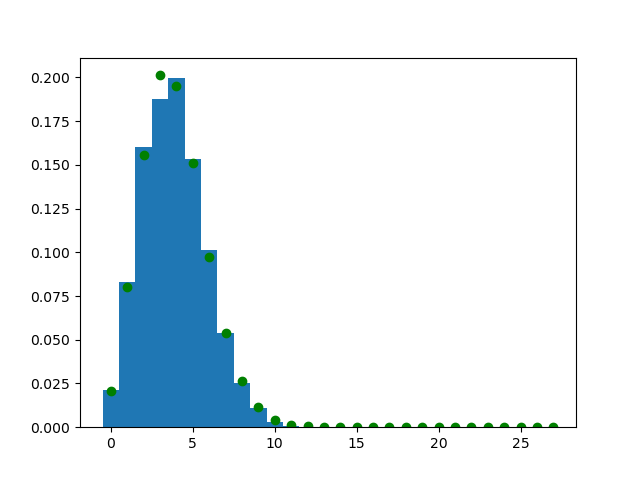

In [322]:
# Precalculate distribution for blanks
from functools import reduce

samps=np.arange(10)
dists=[stats.poisson.pmf(samps,blank_rates[cat]) for cat in cats]

blank_sum_dist=reduce(np.convolve,dists)
# Trim trailing zeros
last_nonzero=np.nonzero(blank_sum_dist)[0][-1]
blank_sum_dist=blank_sum_dist[:last_nonzero+1]

if 1: # "verify" distribution against sampling
    # First, the "empirical" distribution
    blanks=[np.sum( [stats.poisson.rvs(blank_rates[cat]) for cat in cats])
            for _ in range(5000)]
    plt.figure()
    # Very close. Not sure why the peak is slightly shifted.
    plt.hist(blanks,density=True,bins=np.arange(25)-0.5)
    plt.plot(blank_sum_dist,'go')

In [347]:
# The real setup
from scipy.special import logsumexp

def log_prior(theta):
    beach_rate,depo_rate,decay_rate=theta
    if beach_rate<0 or depo_rate<0 or decay_rate<0:
        return -np.inf
    return 0  # flat prior for non-negative values

# theta is parameter vector.
ncalls=0
def log_likelihood(theta,alpha,scale=1.0):
    global ncalls
    ncalls+=1
    LL=0.0
    beach_rate,depo_rate,decay_rate=theta

    df=predict_mantas_fast(decay_rate=decay_rate,
                           beach_rate=beach_rate,
                           depo_rate=depo_rate)

    sigma=1.0 # log units
    LL=0

    cats=['Fiber Bundle','Fragment','Foam', 'Film','Sphere']
    
    for idx,rec in df.iterrows():
        o=rec['count_preblank_nofiber']
        m=scale * rec['C_model'] * rec['area_m2']
        # ? o=max(o,detect_limit)
        
        if np.isinf(m):
            print("Model result was nan for ",theta)
            return -np.inf
        # Previous way:
        #ll = stats.norm.logpdf( np.log(o), np.log(m), sigma ) 
        
        # o ~ m + Pois(blank_rates['Fiber Bundle'])
        #       + Pois(blank_rates['Fragment'])
        #       + Pois(blank_rates['Foam'])
        #       + Pois(blank_rates['Film'])
        #       + Pois(blank_rates['Sphere']) 
        # Poisson is terrible here
        # ll = stats.poisson.logpmf(o, m+blanks)
        # alpha=3.37 # fit below
        # convert to the parameters scipy wants
        mu=m
        sigma2=mu+alpha*mu**2
        p=mu/sigma2 
        n=1/alpha 
        if 0: # sampling approach to deal with blanks
            # This is going to be -inf sometimes!!
            # And chances are one of the samples will end up nan
            # The clip here is not quite right I think
            blanks=np.sum( [stats.poisson.rvs(blank_rates[cat]) for cat in cats])
            ll = stats.nbinom.logpmf( (o-blanks).clip(0) ,n,p)
        if 1: # integration approach for blanks
            lls=[]
            for nblank,pm in enumerate(blank_sum_dist):
                if (pm>0.0) and (o-nblank)>=0:
                    lls.append( np.log(pm) + stats.nbinom.logpmf(o-nblank,n,p))
                else:
                    pass # probability=0
            ll=logsumexp(lls)

        # print(f"obs: {o}  mod: {m}  blanks: {blanks}   log PMF: {ll}")        
        LL+=ll
    return LL

# Original alpha=3.37 came from fitting NegativeBinomial to the full set of
# observations with some nominal blank subtraction.
# After finding some decent parameters with that alpha, a second optimization
# step (starting from the result of the first), additionally tuned alpha and
# finds alpha=1.75. So that's now the default here.
def log_posterior(theta,alpha=1.75):
    l=log_prior(theta)
    if np.isfinite(l):
        l += log_likelihood(theta,alpha=alpha)
    return l

dims=['beach','depo','decay']
ndim = len(dims)  # number of parameters in the model

<IPython.core.display.Javascript object>


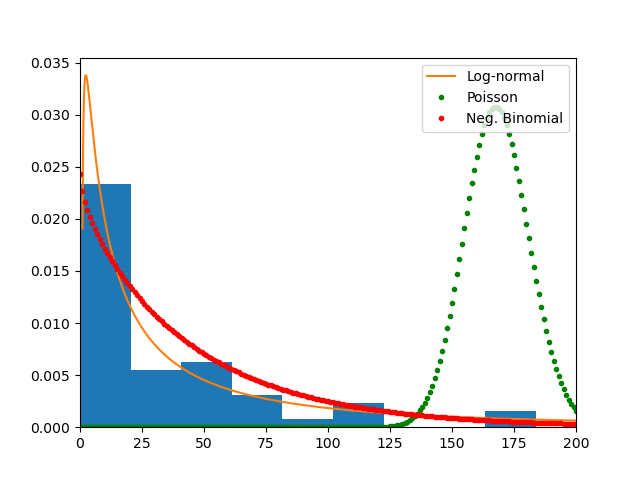

Log-normal: s=1.7120457489598218 loc=0.744863588088174 scale=29.854551406122553
n: 0.95   p: 0.02 =>  mean: 46.55


(0.0, 200.0, 0.0, 0.03548570972344275)

In [202]:
# parameters are n,p:
# n: 
# p: [0,1]
#stats.nbinom.logpmf(490n,p)

# Compare poisson and log normal, then add in nbinom
fig,ax=plt.subplots()
obs=df['count_preblank_nofiber']
x=np.logspace(0,3,1000)
bins=np.linspace(0,1000,50)
ax.hist(df['count_preblank_nofiber'],density=True,bins=bins)
s,loc,scale=stats.lognorm.fit(obs.clip(1.))
ax.plot(x,stats.lognorm.pdf(x,s,loc=loc,scale=scale),label="Log-normal")
print(f"Log-normal: s={s} loc={loc} scale={scale}")

xd=np.arange(0,1000)
ax.plot(xd,stats.poisson.pmf(xd,obs.mean()),'g.',label='Poisson')


# Negative binomial - hand "fit"
xd=np.arange(0,1000)
# n=0.8, p=0.01
# mean is n*(1-p)/p, for scipy's parameters
n=0.95 ; p=0.020

ax.plot(xd,stats.nbinom.pmf(xd,n,p),'r.',label='Neg. Binomial')
# So those values would give mean of 0.012.  Too low.
print(f"n: {n}   p: {p} =>  mean: {n*(1-p)/p}")
ax.legend(loc='upper right')
ax.axis(xmin=0,xmax=200)

<IPython.core.display.Javascript object>


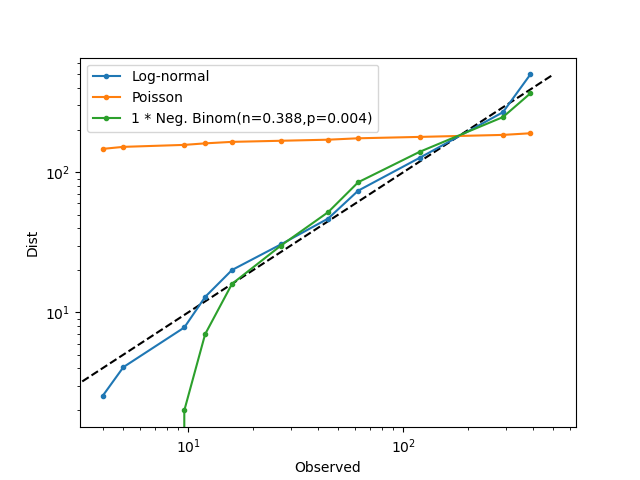

Optimization terminated successfully.
         Current function value: 5.692198
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14
alpha: 2.574501603916001


Text(0, 0.5, 'Dist')

In [325]:
# Attempt Q-Q plots
# This is not quite the right test, but still helpful.
# There is variance that is both real and captured by the model,
# and then there is sampling variance that is not captured by 
# the model. I really just want to know the distribution of the
# unmodeled variance, but these plots consider the variance of
# the samples.
pctiles=np.array([5,10,20,30,40,50,60,70,80,90,95])

# Crude approximation for contamination rates
# This makes quite a difference -- with no correction
# log-normal is clearly best, but with a reasonable-ish
# count of 4 or so lognormal gets quite bad, I think because
# it can't handle the 0s, which have to be mapped to 1, and
# then it has this 1-inflation.
obs_noblank=(obs-6).clip(0)
obs_noblank=(obs-0).clip(0)

fig,ax=plt.subplots()
s,loc,scale=stats.lognorm.fit(obs_noblank.clip(1.))

ax.plot(np.percentile(obs_noblank,pctiles),
        stats.lognorm.ppf(pctiles/100.,s,loc=loc,scale=scale),
        marker='.',
        label="Log-normal")

ax.plot(np.percentile(obs_noblank,pctiles),
        stats.poisson.ppf(pctiles/100.,obs_noblank.mean()),
        marker='.',
        label="Poisson")

obs_mean=obs.mean()
obs_var=obs.var()

#hand-tuned:
#n=0.8
#p=0.008
#scale=1.0

# Fit by statsmodels:
from statsmodels.discrete.discrete_model import NegativeBinomial
nb=NegativeBinomial(obs_noblank,exog=np.ones_like(obs))
result=nb.fit()
result

result.params # constant 5.12, alpha=2.57. I think that's a mu and alpha
result.summary()

mu,alpha=result.params
# This gets the Q-Q plot closer, except the NB seems to have a more inflated zero.
mu*=17 # why is this necessary?
print(f"alpha: {alpha}")
sigma2=mu+alpha*mu**2
p=mu/sigma2 # 0.0704
n=1/alpha # 0.388
scale=1 # manual
# Gives okay slope, but needs a factor of about 17?

# Calculate from observed variance and mean gave bad results.

ax.plot(np.percentile(obs_noblank,pctiles),
        scale*stats.nbinom.ppf(pctiles/100.,n,p),
        marker='.',label=f'{scale} * Neg. Binom(n={n:.3f},p={p:.3f})')

ax.plot([0,500],[0,500],'k--',zorder=-1)
ax.legend(loc='upper left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Observed')
ax.set_ylabel('Dist')

In [348]:
nwalkers = 6  # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 4000  # number of MCMC steps to take

# with sigma=1.0, needed 2000+2000 to converge.
# How many calls?? 24k
# = 6 * 4000 

starting_guesses = np.random.rand(nwalkers, ndim)
# we'll start at random locations between 0 and 0.5
starting_guesses[:,0] *= 0.5 # beach rate [0,0.5]
starting_guesses[:,1] *= 0.1 # depo rate [0,0.1]
starting_guesses[:,2] *= 0.1 # decay rate [0,0.1]

back=emcee.backends.HDFBackend("samples-emcee-v01-nbinom_alpha1.75.h5")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[],
                               backend=back)

sampler.run_mcmc(starting_guesses, nsteps,progress=True)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points

100%|██████████| 4000/4000 [13:48:48<00:00, 12.43s/it]  


<IPython.core.display.Javascript object>


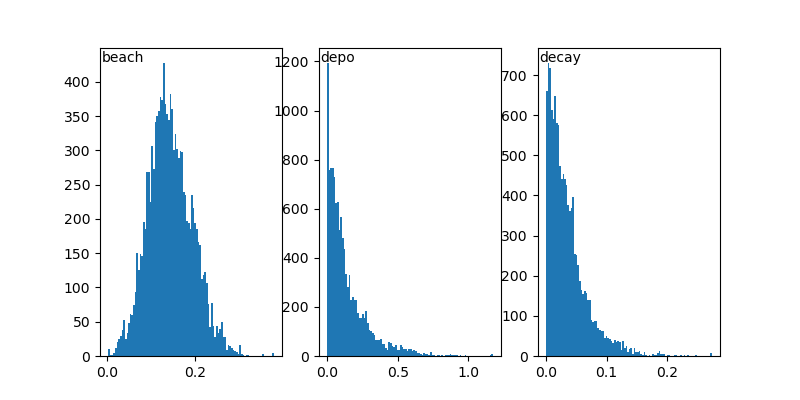

In [350]:
# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points
fig,axs=plt.subplots(1,ndim,figsize=(8,4))
for i,(ax,dim) in enumerate(zip(axs,dims)):
    ax.hist(sample[:,:,i].ravel(),
            bins=100)
    ax.text(0.01,0.99,dim,transform=ax.transAxes,va='top')

<IPython.core.display.Javascript object>


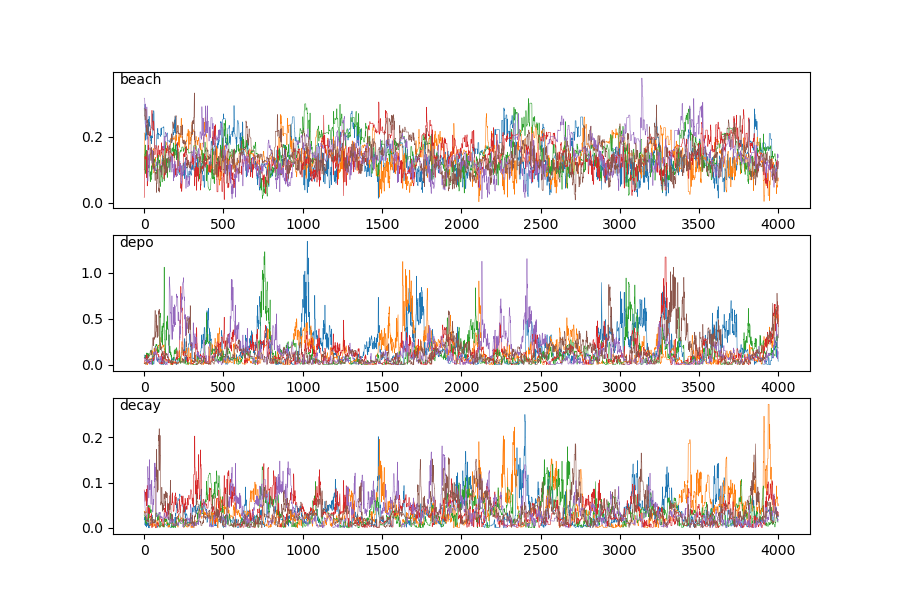

In [354]:
fig,axs=plt.subplots(ndim,1,figsize=(9,6))
for i,(ax,dim) in enumerate(zip(axs,dims)):
    ax.plot( sampler.chain[:,:,i].T,lw=0.4)
    ax.text(0.01,0.99,dim,transform=ax.transAxes,va='top')

In [328]:
from scipy.optimize import minimize

# Seems to be pretty slow to get burn in, still hasn't really gotten
# to a good neighborhood.
# Get a max a posteriori estimate, which might be a better starting point
# for the sampling.
# This yields [0.229,0,0]
# How sensitive is that alpha? Hand-tuning shows that using the output of
# this optimization, then adjust alpha, alpha=1.8+-0.2
x0=[0.1,0.01,0.01]
def cb(xk):
    print("Iteration: ",xk)    
def cost(theta):
    lp=log_posterior(theta)
    print("log posterior %20f  for theta=%s"%(lp,theta))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1)],
                callback=cb,options=dict(disp=True))
result.x

log posterior          -340.478226  for theta=[0.1  0.01 0.01]
log posterior          -340.478225  for theta=[0.10000001 0.01       0.01      ]
log posterior          -340.478226  for theta=[0.1        0.01000001 0.01      ]
log posterior          -340.478226  for theta=[0.1        0.01       0.01000001]
log posterior          -613.745981  for theta=[1. 1. 1.]
log posterior          -613.745979  for theta=[0.99999999 1.         1.        ]
log posterior          -613.745981  for theta=[1.         0.99999999 1.        ]
log posterior          -613.745979  for theta=[1.         1.         0.99999999]
log posterior          -344.270728  for theta=[0.19628868 0.11591755 0.11591755]
log posterior          -344.270729  for theta=[0.19628869 0.11591755 0.11591755]
log posterior          -344.270728  for theta=[0.19628868 0.11591756 0.11591755]
log posterior          -344.270729  for theta=[0.19628868 0.11591755 0.11591756]
log posterior          -338.638838  for theta=[0.13113386 0.04424725 0

INFO:utils:64


log posterior          -338.551421  for theta=[0.13480314 0.04202135 0.03766006]
log posterior          -338.551421  for theta=[0.13480314 0.04202134 0.03766007]
Iteration:  [0.13480314 0.04202134 0.03766006]
log posterior          -338.157494  for theta=[0.16738171 0.02499274 0.        ]
log posterior          -338.157494  for theta=[0.16738172 0.02499274 0.        ]
log posterior          -338.157494  for theta=[0.16738171 0.02499275 0.        ]
log posterior          -338.157494  for theta=[1.67381709e-01 2.49927418e-02 1.00000000e-08]
Iteration:  [0.16738171 0.02499274 0.        ]
log posterior          -337.893312  for theta=[0.19352454 0.0125225  0.        ]
log posterior          -337.893311  for theta=[0.19352455 0.0125225  0.        ]
log posterior          -337.893312  for theta=[0.19352454 0.01252251 0.        ]
log posterior          -337.893312  for theta=[1.93524536e-01 1.25225040e-02 1.00000000e-08]
Iteration:  [0.19352454 0.0125225  0.        ]
log posterior          -3

array([0.22877981, 0.        , 0.        ])

In [344]:
theta=[0.229,0,0]
# Not bad -- suggests alpha~1.80
for alpha in [1,1.2,1.4,1.6,1.8,2,2.2,2.5,2.8,2.9,3.0,3.1,3.2,3.3,3.4]:
    # Knowing that alpha was fit across samples that had a lot of modeled
    # variance in addition to unmodeled variance, explore smaller alpha
    lp=log_posterior(theta,alpha=alpha)
    print(f"alpha={alpha:5.2f}  lp={lp:.6f}")

alpha= 1.00  lp=-337.495248
alpha= 1.20  lp=-334.043099
alpha= 1.40  lp=-332.278827
alpha= 1.60  lp=-331.515305
alpha= 1.80  lp=-331.377828
alpha= 2.00  lp=-331.646959
alpha= 2.20  lp=-332.187077
alpha= 2.50  lp=-333.322451
alpha= 2.80  lp=-334.694309
alpha= 2.90  lp=-335.184557
alpha= 3.00  lp=-335.686421
alpha= 3.10  lp=-336.197642
alpha= 3.20  lp=-336.716303
alpha= 3.30  lp=-337.240769
alpha= 3.40  lp=-337.769643


In [345]:
# Start with the result of that optimization, but now also tune alpha.
x0=[0.1,0.01,0.01,1.8]
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    theta,alpha=theta[:-1],theta[-1]
    lp=log_posterior(theta,alpha=alpha)
    print("log posterior %20f  for theta=%s alpha=%.4f"%(lp,theta,alpha))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1),(1,3.4)],
                callback=cb,options=dict(disp=True))
result.x # [0.22875575, 0.        , 0.        , 1.75525524]

log posterior          -336.609574  for theta=[0.1  0.01 0.01] alpha=1.8000
log posterior          -336.609572  for theta=[0.10000001 0.01       0.01      ] alpha=1.8000
log posterior          -336.609573  for theta=[0.1        0.01000001 0.01      ] alpha=1.8000
log posterior          -336.609573  for theta=[0.1        0.01       0.01000001] alpha=1.8000
log posterior          -336.609573  for theta=[0.1  0.01 0.01] alpha=1.8000
log posterior          -611.904095  for theta=[1. 1. 1.] alpha=3.4000
log posterior          -611.904093  for theta=[0.99999999 1.         1.        ] alpha=3.4000
log posterior          -611.904094  for theta=[1.         0.99999999 1.        ] alpha=3.4000
log posterior          -611.904093  for theta=[1.         1.         0.99999999] alpha=3.4000
log posterior          -611.904096  for theta=[1. 1. 1.] alpha=3.4000
log posterior          -348.667362  for theta=[0.22339328 0.1457326  0.1457326 ] alpha=2.0194
log posterior          -348.667363  for theta=[0.2

log posterior          -331.382112  for theta=[0.23274095 0.         0.        ] alpha=1.8000
Iteration:  [0.23274095 0.         0.         1.80001996]
log posterior          -331.374451  for theta=[0.23306315 0.         0.        ] alpha=1.7758
log posterior          -331.374451  for theta=[0.23306316 0.         0.        ] alpha=1.7758
log posterior          -331.374452  for theta=[2.3306315e-01 1.0000000e-08 0.0000000e+00] alpha=1.7758
log posterior          -331.374451  for theta=[2.3306315e-01 0.0000000e+00 1.0000000e-08] alpha=1.7758
log posterior          -331.374451  for theta=[0.23306315 0.         0.        ] alpha=1.7758
Iteration:  [0.23306315 0.         0.         1.77578522]
log posterior          -331.368800  for theta=[0.23121591 0.         0.        ] alpha=1.7560
log posterior          -331.368800  for theta=[0.23121592 0.         0.        ] alpha=1.7560
log posterior          -331.368801  for theta=[2.31215908e-01 1.00000000e-08 0.00000000e+00] alpha=1.7560
log post

array([0.22875575, 0.        , 0.        , 1.75525524])

In [456]:
# after the fact save those to HDF backend
# Not actually possible.
# Save the xarray instead

#ds=xr.Dataset()
#ds['param']=('param',),dims
#ds['chain']=('walker','step','param'),sampler.chain
#ds.attrs['notes']="""Log-normal distribution
#no handling for catch efficiency, count data, etc.
#"""
#ds.to_netcdf("XXbase-samples.nc")

In [393]:
theta=[0.1,0.000,0.022]
log_likelihood(theta,data) # -86 for "true"

# For beaching, seems biased low a small amt.
# Deposition: big penalty, constrained to <1e-4
# A lot comes down to sigma.
# sigma of 1.0 makes it all fuzzy.
# sigma of 0.1 it's fairly precise.

53.6590071421893

In [234]:
# with 1000 parts per sample, 1 chain, shore only: 34s
# 1000 parts per sample, 4 chains, shore+decay: 2:02.
#                        1 chain              : 1:35
#                        1 chain, shore+bed+decay: 5:33
# 2000 .... ? 13:00
# 200 samples: 23.2s
# Likely missing some stan optimizations.
# would log_sum_exp help? likely not -- it's for numerical robustness, not speed.


1.13113670878904

In [288]:
# the tests above are for 1000 parts/sample
# my actual data has 12M(!)
# So expect 12k times slower. So it could take 41 days to fit.
# 5*12000/60/24

# Can precalc log(preweight), and slightly simplify the 
# pred calculation: does not make a difference.
# Can calculate all parts at once, then sum in the loop. no help.


41.666666666666664